# Naive Bayes Classifier (fit, predict, and predict probabilities)

In [62]:
class naivebayes:
    
    def __init__(self):
        self.var_mean = {}
        self.prob_c = {}
        self.attribute_probabilities = []
        
    #Predicts labels given a set of vectors, either numpy arrays or pandas series
    def gauss_predict(self, vectors):
        import numpy as np
        self.attribute_probabilities = []
        
        #calculate datapoints' probability given a label of class c
        labels = []
        for i in self.prob_c.keys():
            attribute_probability = []
            for n in range(len(vectors[0])):
                var = self.var_mean[i][n][0]
                mean = self.var_mean[i][n][1]
                #I split up the calculation below so that it was tidier/easier to read
                coefficient = 1.0 / ((2.0*np.pi*var)**0.5)
                gauss = lambda x:coefficient * (np.e**(-((x - mean)**2.0)/(2.0*var)))
                #applies the gaussian probability to each datapoint in an attribute
                ap = [gauss(d) for d in vectors.take(n,1)]
                attribute_probability.append(ap)
            #finds the product of all conditionally independent probabilities
            attribute_probability = np.prod(attribute_probability,axis = 0)
            #multiplies each probability by the class prior probability
            attribute_probability = attribute_probability * self.prob_c[i]
            self.attribute_probabilities.append(attribute_probability)
        attribute_probabilities = np.array(self.attribute_probabilities)
        #Prediction 
        classes = [i for i in self.prob_c.keys()]
        for i in range(len(attribute_probabilities[0])):
            biggest_prob = max(attribute_probabilities.take(i,1))
            label = int(np.where(attribute_probabilities == max(attribute_probabilities.take(i,1)))[0][0])
            labels.append(classes[label])
        return labels 
    
    #shows the probabilities for each class for each datapoint
    def predict_proba(self, vectors):
        import numpy as np
        self.gauss_predict(vectors)
        attribute_probabilities = np.array(self.attribute_probabilities)
        normalized_ap = []
        for i in range(len(attribute_probabilities[0])):
            total_prob = sum(attribute_probabilities.take(i,1))
            normalized_ap.append(attribute_probabilities.take(i,1)/total_prob)
        probs = np.array([[i[0],i[1]] for i in normalized_ap])
        return probs
    
  
    
    #X and y inputs must be pandas dataframe or numpy arrays    
    def fit(self,X,y, mle = True):
        import numpy as np
        labels = np.unique(y)
     
        #estimate class priors
        probabilities_of_c = [float(sum(c == y))/len(y) for c in labels]
        #append class probabilities into predefined dictionary
        for n,label in enumerate(labels):
            self.prob_c[label] = probabilities_of_c[n]
        
                   
        #variance and mean for each attribute in a class
        for label in labels:
            self.var_mean[label] = []
            matching = X[np.where(y == label)]
            for i in range(len(matching[0])):
                # m is the "coefficient" for the maximum likelihood estimation of variance
                if mle == True:
                    m = (len(matching.take(i,1)) - 1 )/ len(matching.take(i,1))
                else:
                    m = 1
                var = np.var(matching.take(i,1), ddof = 1) * m
                mean = np.mean(matching.take(i,1))
                self.var_mean[label].append([var,mean])       
                

Create an instance of the naive bayes classifier

# Import data and scale it

In [2]:
import pandas as pd
df = pd.read_csv('winequality-red.csv', delimiter = ';')
q = lambda x:1 if x>= 7 else 0
df['binary_quality'] = df['quality'].apply(q)
data = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
labels = df['binary_quality']
#choice_data = df[['volatile acidity', 'citric acid', 'residual sugar',
 #                 'free sulfur dioxide','total sulfur dioxide', 'pH', 'sulphates']]
from sklearn.preprocessing import scale, StandardScaler
#scaler = StandardScaler()
scaled_data = scale(data, axis = 0)
#scaled_data = scaler.fit_transform(choice_data)

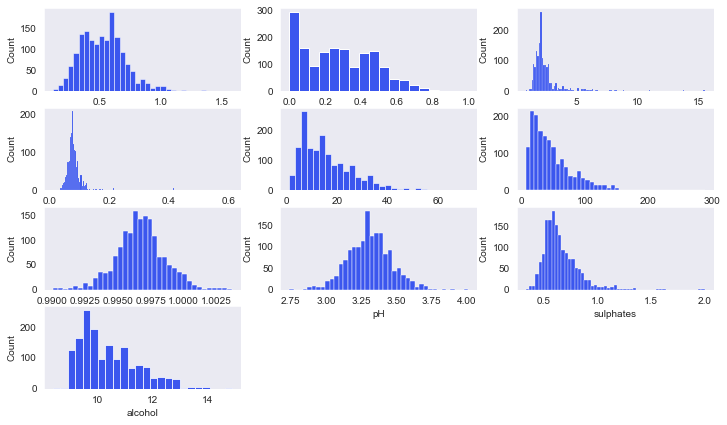

In [131]:
plt.figure(figsize = (12,7))
#plt.subplot(4,3,1)
columns = data.columns
for i in range(1,11):
    plt.subplot(4,3,i)
    sns.histplot(data = data, x = columns[i], common_norm = True)

I was doing a bunch of different checks on my scores. You can mostly ignore this section

In [106]:
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
nb = naivebayes()
X = scaled_data
y = df['binary_quality']
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,
    random_state=34)
skp = []
myp = []
skr = []
myr = []
skprob = []
myprob = []
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    clf.fit(X_train, y_train)
    nb.fit(X_train,y_train)
    sk_y_pred = clf.predict(X_test)
    my_y_pred = nb.gauss_predict(X_test)
    skprob.append(clf.predict_proba(X_test))
    myprob.append(nb.predict_proba(X_test))
    skp.append(precision_score(y_test, sk_y_pred))
    myp.append(precision_score(y_test, my_y_pred))
    skr.append(recall_score(y_test, sk_y_pred))
    myr.append(recall_score(y_test, my_y_pred))
  

In [107]:
myp_nomle = []
myr_nomle = []
myprob_nomle = []
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    nb.fit(X_train,y_train, mle = False)
    my_y_pred = nb.gauss_predict(X_test)
    myprob_nomle.append(nb.predict_proba(X_test))
    myp_nomle.append(precision_score(y_test, my_y_pred))
    myr_nomle.append(recall_score(y_test, my_y_pred))
    

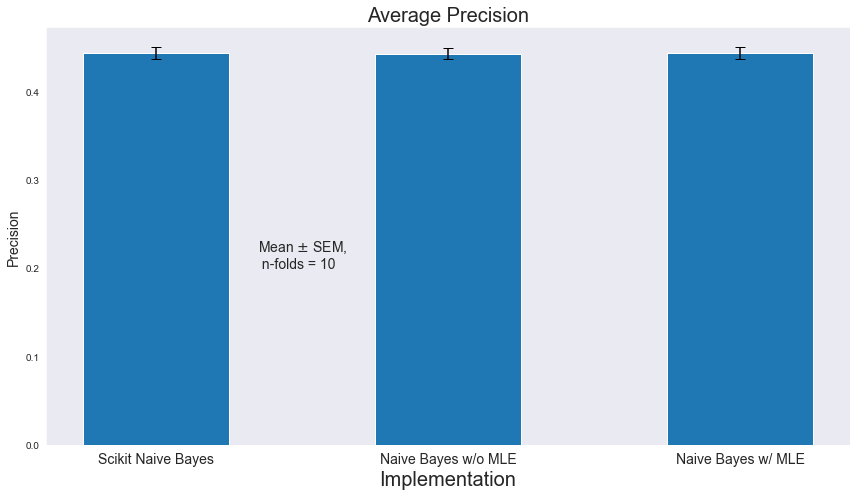

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import sem
sns.set_style('dark')
sk_error = sem(skp)
my_error = sem(myp) 
my_error_nomle = sem(myp_nomle) 
height = [np.mean(skp),np.mean(myp_nomle),np.mean(myp)]
plt.figure(figsize = (12,7))
plt.bar(x = [1,2,3],height = height, yerr = [sk_error, my_error_nomle, my_error], 
        capsize = 5, align = 'center', width = 0.5)
plt.xticks(ticks = [1,2,3], labels = ["Scikit Naive Bayes","Naive Bayes w/o MLE", 'Naive Bayes w/ MLE'], 
           fontsize = 14)
plt.ylabel("Precision", fontsize = 14)
plt.xlabel("Implementation", fontsize = 20)
plt.title('Average Precision',fontsize = 20)
plt.annotate('Mean $\pm$ SEM, \n n-folds = 10',xy = (1.35,0.2), fontsize = 14)
plt.tight_layout()
#plt.savefig('Barplot SK vs NB w MLE.png',bbox_inches='tight')

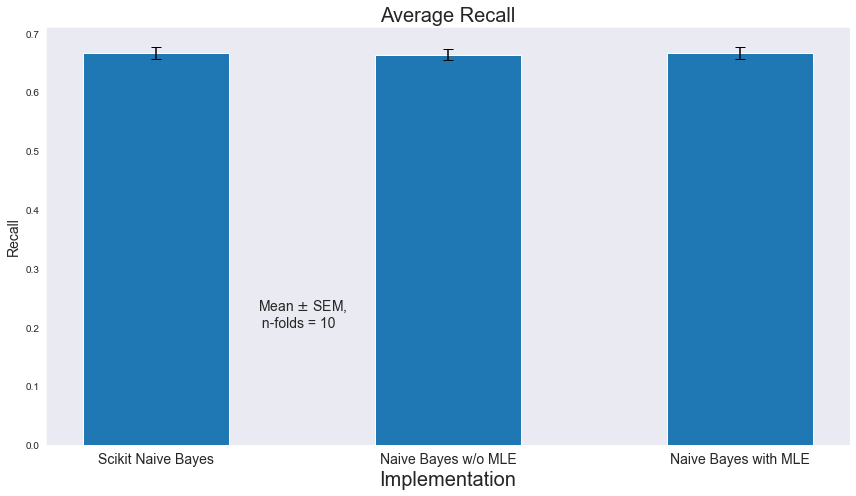

In [109]:
sk_error = sem(skr)
my_error = sem(myr) 
my_error_nomle = sem(myr_nomle) 
height = [np.mean(skr),np.mean(myr_nomle),np.mean(myr)]
plt.figure(figsize = (12,7))
plt.bar(x = [1,2,3],height = height, yerr = [sk_error, my_error_nomle, my_error], 
        capsize = 5, align = 'center', width = 0.5)
plt.xticks(ticks = [1,2,3], labels = ["Scikit Naive Bayes", 'Naive Bayes w/o MLE',"Naive Bayes with MLE"], 
           fontsize = 14)
plt.ylabel("Recall", fontsize = 14)
plt.xlabel("Implementation", fontsize = 20)
plt.title('Average Recall',fontsize = 20)
plt.annotate('Mean $\pm$ SEM, \n n-folds = 10',xy = (1.35,0.2), fontsize = 14)
plt.tight_layout()

In [152]:
p_table = pd.DataFrame({'n-fold':[i for i in range(1,101)],'Scikit':skp,
                        'Naive Bayes w/o MLE':myp_nomle,
                        'Naive Bayes w/ MLE':myp})
p_table.reset_index(drop = True, inplace = True)
avg_p_table = pd.DataFrame({'Method':["Scikit Naive Bayes", 
                            'Naive Bayes w/o MLE',"Naive Bayes with MLE"],
                'Mean Precision':[np.mean(skp),np.mean(myp_nomle),np.mean(myp)],
                 'SEM':[sem(skp),sem(myp_nomle),sem(myp)]})
avg_p_table
print(avg_p_table.to_latex(index=False))                    

\begin{tabular}{lrr}
\toprule
              Method &  Mean Precision &      SEM \\
\midrule
  Scikit Naive Bayes &        0.443412 & 0.006499 \\
 Naive Bayes w/o MLE &        0.442805 & 0.006500 \\
Naive Bayes with MLE &        0.443412 & 0.006499 \\
\bottomrule
\end{tabular}



/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_85098/39771918.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(avg_p_table.to_latex(index=False))


In [158]:
sum(p_table['Naive Bayes w/ MLE'] > p_table[ 'Naive Bayes w/o MLE'])

13

In [30]:
r_table = pd.DataFrame({'n-fold':[i for i in range(1,11)],'Scikit':skr,
                        'Naive Bayes w/o MLE':myr_nomle,
                        'Naive Bayes w/ MLE':myr})
r_table.reset_index(drop = True, inplace = True)
r_table


n-fold    Scikit  Naive Bayes w/o MLE  Naive Bayes w/ MLE
0       1  0.380952             0.380952            0.380952
1       2  0.428571             0.428571            0.428571
2       3  0.863636             0.863636            0.863636
3       4  0.863636             0.818182            0.863636
4       5  0.545455             0.545455            0.545455
5       6  0.772727             0.772727            0.772727
6       7  0.636364             0.681818            0.636364
7       8  0.636364             0.636364            0.636364
8       9  0.727273             0.727273            0.727273
9      10  0.571429             0.571429            0.571429

In [153]:
avg_r_table = pd.DataFrame({'Method':["Scikit Naive Bayes", 
                            'Naive Bayes w/o MLE',"Naive Bayes with MLE"],
                'Mean Recall':[np.mean(skr),np.mean(myr_nomle),np.mean(myr)],
                 'SEM':[sem(skr),sem(myr_nomle),sem(myr)]})
avg_r_table
print(avg_r_table.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
              Method &  Mean Recall &      SEM \\
\midrule
  Scikit Naive Bayes &     0.666623 & 0.009555 \\
 Naive Bayes w/o MLE &     0.663420 & 0.009533 \\
Naive Bayes with MLE &     0.666623 & 0.009555 \\
\bottomrule
\end{tabular}



/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_85098/696424690.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(avg_r_table.to_latex(index=False))


In [161]:
avg_table = pd.DataFrame({'Method':["Scikit Naive Bayes", 
                            'Naive Bayes w/o MLE',"Naive Bayes with MLE"],
                'Mean Precision':[np.mean(skp),np.mean(myp_nomle),np.mean(myp)],
                 'Precision SEM':[sem(skp),sem(myp_nomle),sem(myp)]})
avg_table['Mean Recall'] = [np.mean(skr),np.mean(myr_nomle),np.mean(myr)]
avg_table['Recall SEM'] = [sem(skr),sem(myr_nomle),sem(myr)]
avg_table
print(avg_table.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
              Method &  Mean Precision &  Precision SEM &  Mean Recall &  Recall SEM \\
\midrule
  Scikit Naive Bayes &        0.443412 &       0.006499 &     0.666623 &    0.009555 \\
 Naive Bayes w/o MLE &        0.442805 &       0.006500 &     0.663420 &    0.009533 \\
Naive Bayes with MLE &        0.443412 &       0.006499 &     0.666623 &    0.009555 \\
\bottomrule
\end{tabular}



/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_85098/3154035216.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(avg_table.to_latex(index=False))


In [94]:
one = {'Scikit':skprob[3][:,1], 
                        'Naive Bayes w/o MLE':myprob_nomle[3][:,1],
                        'Naive Bayes w/ MLE':myprob[3][:,1]}
two = {'Scikit':skprob[6][:,1], 
        'Naive Bayes w/o MLE':myprob_nomle[6][:,1],
        'Naive Bayes w/ MLE':myprob[6][:,1]}
df_one = pd.DataFrame(one)
df_two = pd.DataFrame(two)
prob_df = df_one.join(df_two, lsuffix='_caller', rsuffix='_other')

In [95]:
prob_df

Scikit_caller  Naive Bayes w/o MLE_caller  Naive Bayes w/ MLE_caller  \
0         0.937214                    0.937533                   0.937214   
1         0.382291                    0.378206                   0.382291   
2         0.858499                    0.858452                   0.858499   
3         0.765181                    0.762195                   0.765181   
4         0.465993                    0.465325                   0.465993   
..             ...                         ...                        ...   
155       0.591041                    0.596929                   0.591041   
156       0.979794                    0.979513                   0.979794   
157       0.962995                    0.962526                   0.962995   
158       0.979794                    0.979513                   0.979794   
159       0.974910                    0.975698                   0.974910   

     Scikit_other  Naive Bayes w/o MLE_other  Naive Bayes w/ MLE_other  
0        0.233089                   0.233513                  0.233089  
1        0.697404                   0.694573                  0.697404  
2        0.453290                   0.449837                  0.453290  
3        0.605117                   0.601462                  0.605117  
4        0.431673                   0.427246                  0.431673  
..            ...                        ...                       ...  
155      0.694213                   0.690304                  0.694213  
156      0.003326                   0.003381                  0.003326  
157      0.009508                   0.009487                  0.009508  
158      0.015710                   0.015758                  0.015710  
159      0.344738                   0.340725                  0.344738  

[160 rows x 6 columns]

0.049695146333979055

0.049695146333979055

0.04935827791713007

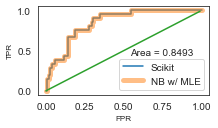

In [176]:
from sklearn import metrics
index = [i for i in rskf.split(X,y)]
X_train, X_test = X[index[1][0]], X[index[1][1]]
y_train, y_test = y[index[1][0]], y[index[1][1]] 
clf.fit(X_train, y_train)
plt.figure(figsize = (3,1.75))
sns.set_style('white')
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
#nb.fit(X_train,y_train, mle = False)
#fpr, tpr, thresholds = metrics.roc_curve(y_test, nb.predict_proba(X_test)[:,1])
#plt.plot(fpr,tpr)
nb.fit(X_train,y_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, nb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,  alpha = 0.5, linewidth = 5)
x = [i/100 for i in range(100)]
plt.plot(x,x)
plt.tight_layout()
plt.ylabel('TPR', fontsize = 8)
plt.xlabel('FPR',fontsize = 8)
#plt.title('ROC Curve for Naive Bayes Classifier', fontsize = 6)
plt.legend(["Scikit", "NB w/ MLE"])
area = round(metrics.roc_auc_score(y_test, nb.predict_proba(X_test)[:,1] ),4)
plt.annotate('Area = '+str(area),xy = (0.54,0.44))
plt.savefig('ROC curve.png')


array([   0,    1,    2, ..., 1596, 1597, 1598])